In [2]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.utils import shuffle
import pandas as pd

In [3]:
class_names = ['NORMAL', 'PNEUMONIA']
class_names_label = {}
for i in range(len(class_names)):
    class_names_label[class_names[i]] = i

img_size = (150, 150)

class_names_label

{'NORMAL': 0, 'PNEUMONIA': 1}

In [4]:
def lungs_segmented(img):
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    ret1, th1 = cv.threshold(gray, 156, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    kernel = np.ones([3,3], np.uint8)
    th1_m = cv.morphologyEx(th1, cv.MORPH_OPEN, kernel, 2)
    th1_m_d = cv.dilate(th1_m, kernel, 3)
    th1_m_d_dt = cv.distanceTransform(th1_m_d, cv.DIST_L2, 5)
    retth1, th1_m_d_dt_th = cv.threshold(th1_m_d_dt, 0.7*th1_m_d_dt.max(), 255, cv.THRESH_BINARY)
    th1_m_d_dt_th = np.uint8(th1_m_d_dt_th)
    unknown = cv.subtract(th1_m_d,th1_m_d_dt_th)
    ret, markers = cv.connectedComponents(th1_m_d_dt_th)
    markers = markers + 1
    markers[unknown==255] = 0
    markers = cv.watershed(img, markers)
    img[markers == -1] = [255, 255,0]
    
    return img

def load_data():
    
    folders = ['../pneumonia_detection/chest_xray/train', '../pneumonia_detection/chest_xray/test']
    df = []
    
    for folder in folders:
        images = []
#         images_segmented = []
        labels = []
        
        print(f'Loading {format(folder)}')
        
        for class_name in os.listdir(folder):
            label = class_names_label[class_name]
            
            for file in tqdm(os.listdir(os.path.join(folder, class_name))):
                img_path = os.path.join(os.path.join(folder, class_name), file)
                
                img = cv.imread(img_path)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = cv.resize(img, img_size)
                
                images.append(img)
#                 images_segmented.append(lungs_segmented(img))
                labels.append(label)

        images = np.array(images, dtype='float32')
#         images_segmented = np.array(images_segmented, dtype='float32')
        labels = np.array(labels, dtype='int32')

#         df.append((images, images_segmented, labels))
        df.append((images, labels))
        
    return df

In [5]:
# (train_images, train_images_segmented, train_labels), (test_images, test_images_segmented, test_labels) = load_data()
(train_images, train_labels), (test_images, test_labels) = load_data()

  0%|                                                                                                                                      | 0/1341 [00:00<?, ?it/s]

Loading ../pneumonia_detection/chest_xray/train


  0%|                                                                                                                                       | 0/234 [00:00<?, ?it/s]

Loading ../pneumonia_detection/chest_xray/test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:08<00:00, 45.19it/s]


In [6]:
train_images.shape, test_images.shape

((5216, 150, 150, 3), (624, 150, 150, 3))

In [7]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

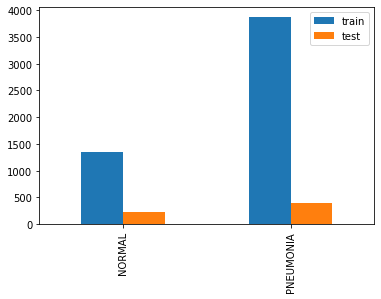

In [8]:
train_counts = np.unique(train_labels, return_counts=True)[1]
test_counts = np.unique(test_labels, return_counts=True)[1]
pd.DataFrame({'train': train_counts, 'test': test_counts}, index=class_names).plot.bar()
plt.show()

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

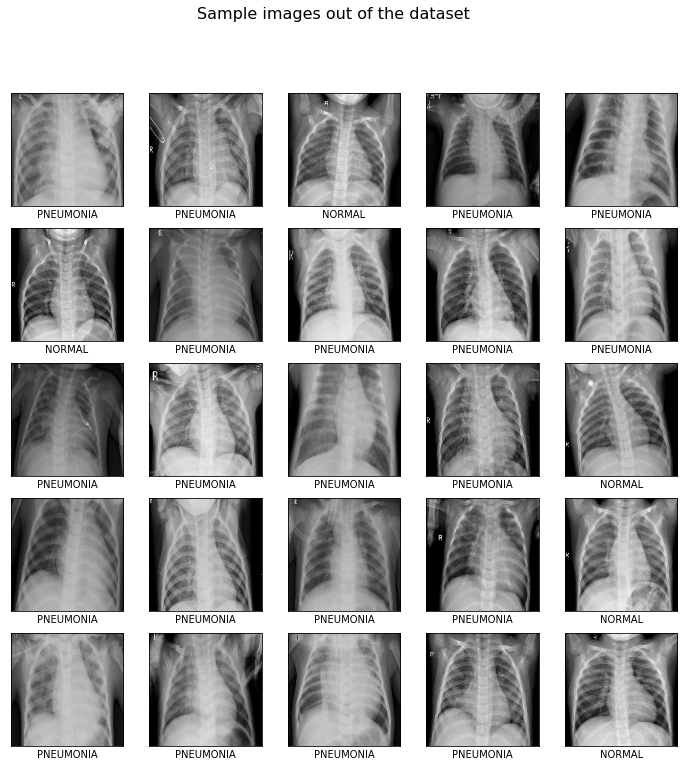

In [10]:
fig = plt.figure(figsize=(12,12))
fig.suptitle("Sample images out of the dataset", fontsize=16)

for i in range(25):
    temp = np.random.randint(0, train_images.shape[0])
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[temp], cmap="binary")
    plt.xlabel(class_names[train_labels[temp]])
plt.show()

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'softmax')
])

In [30]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
train_images.shape, test_images.shape

((5216, 150, 150, 3), (624, 150, 150, 3))

In [32]:
history = model.fit(train_images, train_labels, batch_size=256, epochs=10, validation_split = 0.3)

Epoch 1/10
15/15 [==============================] - 74s 5s/step - loss: 1.8563 - accuracy: 0.5994 - val_loss: 0.5680 - val_accuracy: 0.7476
Epoch 2/10
15/15 [==============================] - 71s 5s/step - loss: 0.5469 - accuracy: 0.7418 - val_loss: 0.3759 - val_accuracy: 0.8722
Epoch 3/10
15/15 [==============================] - 63s 4s/step - loss: 0.3148 - accuracy: 0.8725 - val_loss: 0.2119 - val_accuracy: 0.9144
Epoch 4/10
15/15 [==============================] - 61s 4s/step - loss: 0.1856 - accuracy: 0.9258 - val_loss: 0.1609 - val_accuracy: 0.9425
Epoch 5/10
15/15 [==============================] - 61s 4s/step - loss: 0.1281 - accuracy: 0.9565 - val_loss: 0.1077 - val_accuracy: 0.9642
Epoch 6/10
15/15 [==============================] - 62s 4s/step - loss: 0.0953 - accuracy: 0.9611 - val_loss: 0.0909 - val_accuracy: 0.9681
Epoch 7/10
15/15 [==============================] - 61s 4s/step - loss: 0.0699 - accuracy: 0.9743 - val_loss: 0.0821 - val_accuracy: 0.9706
Epoch 8/10
15/15 [==

In [33]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

20/20 - 4s - loss: 1.0286 - accuracy: 0.7388

Test accuracy: 0.7387820482254028


In [34]:
def plot_loss(history, y_min_val, y_max_val):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([y_min_val, y_max_val])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

def plot_accuracy(history, y_min_val, y_max_val):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.ylim([y_min_val, y_max_val])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

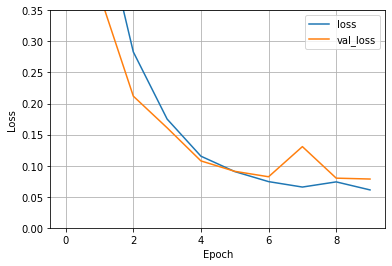

In [35]:
plot_loss(history, 0, 0.35)

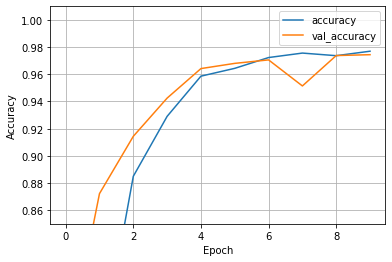

In [36]:
plot_accuracy(history, 0.85, 1.01)

In [37]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [38]:
predictions = probability_model.predict(test_images)

In [39]:
predictions[0]

array([0.552779  , 0.44722104], dtype=float32)

In [40]:
np.argmax(predictions[0])

0

In [41]:
test_labels[0]

0

In [42]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap='binary')

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{}\n{}".format('P: ' + class_names[predicted_label],
                                'T: ' + class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label, classes):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(len(classes)))
    plt.yticks([])
    thisplot = plt.bar(range(len(classes)), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

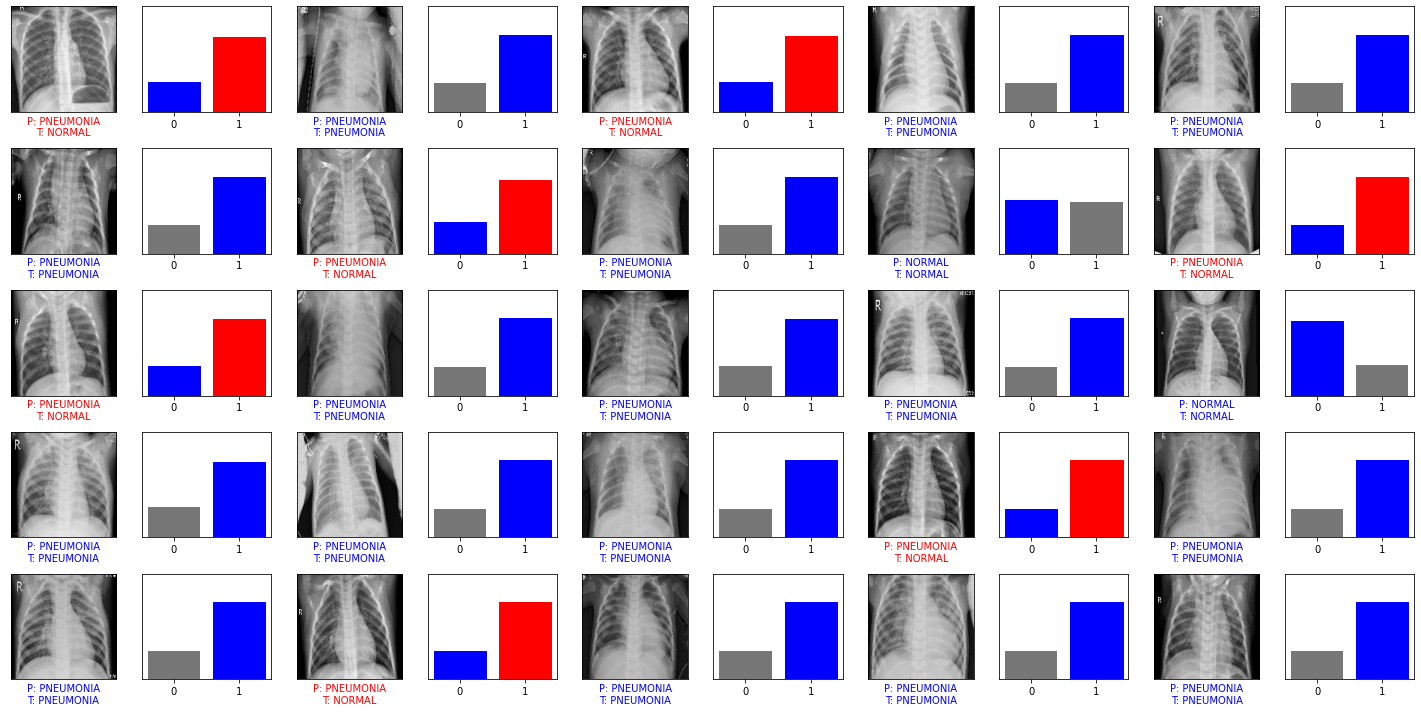

In [48]:
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
temp_list = []
for i in range(num_images):
    temp = np.random.randint(0, test_images.shape[0]-1)
    if temp not in temp_list:
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(temp, predictions[temp], test_labels, test_images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(temp, predictions[temp], test_labels, class_names_label)
        temp_list.append(temp)
    else:
        i -= 1
plt.tight_layout()
plt.show()

In [44]:

print(f'predictions: {len(predictions)}\ntest labels: {len(test_labels)}')

predictions: 624
test labels: 624


In [45]:
true_pneumonia_count = 0
true_normal_count = 0
false_pneumonia_count = 0
false_normal_count = 0
for i in range(len(predictions)):
    if np.argmax(predictions[i]) == test_labels[i]:
        if test_labels[i] == 0:
            true_normal_count += 1
        elif test_labels[i] == 1:
            true_pneumonia_count += 1
    else:
        if test_labels[i] == 0:
            false_pneumonia_count += 1
        elif test_labels[i] == 1:
            false_normal_count += 1

In [46]:
print(f'true normal: {true_normal_count}\nfalse normal: {false_normal_count}\ntrue pneumonia: {true_pneumonia_count}\nfalse pneumonia: {false_pneumonia_count}')

true normal: 72
false normal: 1
true pneumonia: 389
false pneumonia: 162
